In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from uncertainties import *

from uncertainties import ufloat
from uncertainties.umath import *  # sin(), etc.
import uncertainties.umath
import uncertainties

#definitions of the constants
capacitor_distance=0.006 #m
viscosity_air=1.81e-5 #Ns/m^2
density_oil=875 #kg/m^3
density_air=1.29 #kg/m^3
step_value=0.00005 #m
g=9.81 #m/s^2

In [79]:
sinksteig_data=pd.read_csv("Milikan_sinkSteig.csv", header=2)
sinksteig_data

,U/V,U_err/V,t1/s,t1_err/s,t2/s,t2_err/s,scale-steps,scale-steps_err
0,504,1,6.122,0.01,3.281,0.01,3,1.732051
1,512,1,6.634,0.01,2.450,0.01,3,1.732051
2,511,1,4.119,0.01,3.400,0.01,3,1.732051
3,511,1,2.525,0.01,0.862,0.01,3,1.732051
4,523,1,2.881,0.01,2.368,0.01,3,1.732051
5,568,1,8.203,0.01,1.675,0.01,3,1.732051
6,513,1,4.108,0.01,2.883,0.01,3,1.732051
7,515,1,4.536,0.01,3.050,0.01,3,1.732051
8,515,1,5.835,0.01,2.271,0.01,3,1.732051
9,534,1,2.333,0.01,2.204,0.01,3,1.732051


In [20]:
schweben_data=pd.read_csv("Milikan_Schweben.csv")
schweben_data

,U/V,U_err/V,t/s,t_err/s,s/Skalen,s_err
0,225,1,6.070,0.01,5,2.236068
1,138,1,5.281,0.01,3,1.732051
2,113,1,6.591,0.01,3,1.732051
3,175,1,3.573,0.01,3,1.732051
4,56,1,4.193,0.01,3,1.732051


Assume the droplet is $\textbf{floating}$. Hence we have no friction of air. Thus we have:
$Q=\frac{(\rho_{Oil}-\rho_{Air}) g d}{U} \frac{4\pi r^3}{3}$
But fo that formula we also need the radius of the droplet, that is beeing calculated after the following formula:
$r=\sqrt{\frac{9 \eta s}{2 g t (\rho_{Oil}-\rho_{Air})}}$

[2.344243896943926e-19+/-1.5726117964929619e-19
 2.188980469339739e-19+/-1.895789252353322e-19
 1.9172988570999833e-19+/-1.6605219387527945e-19
 3.101756145302649e-19+/-2.6862896543569227e-19
 7.624649841734001e-19+/-6.604600363784179e-19]


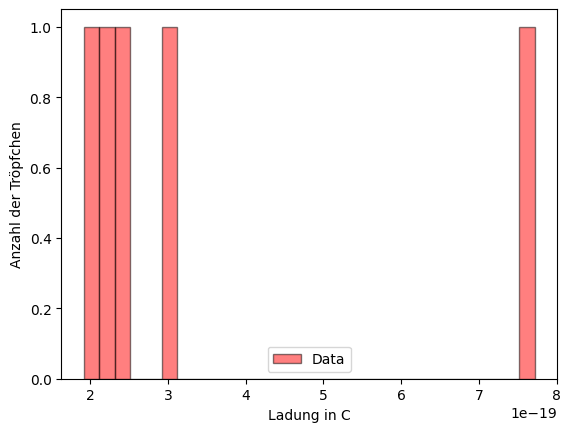

In [87]:
#defining data for steps and time
s=[]
for i in range(len(schweben_data["s/Skalen"])):
    s.append(ufloat(schweben_data["s/Skalen"][i], schweben_data["s_err"][i]))
s=np.array(s)*step_value
t=[]
for i in range(len(schweben_data["t/s"])):
    t.append(ufloat(schweben_data["t/s"][i], schweben_data["t_err/s"][i]))
t=np.array(t)
U=[]
for i in range(len(schweben_data["U/V"])):
    U.append(ufloat(schweben_data["U/V"][i], schweben_data["U_err/V"][i]))
U=np.array(U)

#r squared
r2=9*s*viscosity_air/(2*g*t*(density_oil-density_air))

#Calculating the charge
Q=(density_oil-density_air)*4/3*np.pi*r2**(3/2)*g*capacitor_distance/U
print(Q)

#plotting
plt.hist([Q[i].n for i in range(len(Q))], color="red", label="Data", edgecolor="black",
         bins=np.arange(min([Q[i].n for i in range(len(Q))]), max([Q[i].n for i in range(len(Q))]) + 0.2e-19, 0.2e-19),
         alpha=0.5)
plt.xlabel("Ladung in C")
plt.ylabel("Anzahl der Tröpfchen")
plt.legend()
plt.show()

Calculation of the elementary charge thorugh sinksteig method. 

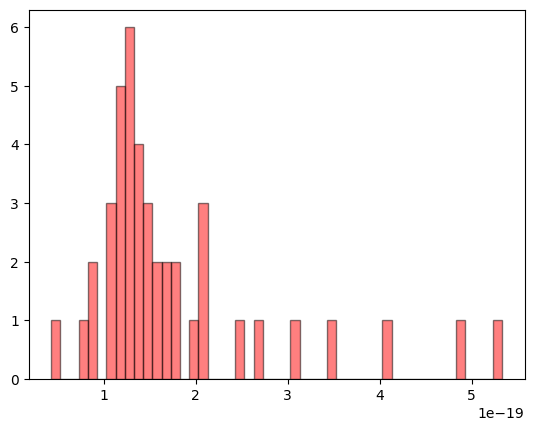

In [95]:
#defining the data
s=[]
for i in range(len(sinksteig_data["scale-steps"])):
    s.append(ufloat(sinksteig_data["scale-steps"][i], sinksteig_data["scale-steps_err"][i]))
s=np.array(s)*step_value
t1=[]
for i in range(len(sinksteig_data["t1/s"])):
    t1.append(ufloat(sinksteig_data["t1/s"][i], sinksteig_data["t1_err/s"][i]))
t1=np.array(t1)
t2=[]
for i in range(len(sinksteig_data["t2/s"])):
    t2.append(ufloat(sinksteig_data["t2/s"][i], sinksteig_data["t2_err/s"][i]))
t2=np.array(t2)
U=[]
for i in range(len(sinksteig_data["U/V"])):
    U.append(ufloat(sinksteig_data["U/V"][i], sinksteig_data["U_err/V"][i]))
U=np.array(U)

#calculating the velocities
v1=s/t1
v2=s/t2

r2=9*s*viscosity_air/(2*g*t1*(density_oil-density_air))
r=r2**(1/2)
Q=capacitor_distance/U*((density_oil-density_oil)*4/3*np.pi*r**3*g+6*np.pi*r*viscosity_air*v2)
plt.hist([Q[i].n for i in range(len(Q))], color="red", label="Data", edgecolor="black",
         bins=np.arange(min([Q[i].n for i in range(len(Q))]), max([Q[i].n for i in range(len(Q))]) + 0.1e-19, 0.1e-19),
         alpha=0.5)
plt.show()